In [1]:
import pandas as pd
import seaborn as sns

In [32]:
results = pd.read_csv('../data/results.csv')
teams = pd.read_csv('../data/teams.csv')

In [33]:
def results_points(a, b):
    """ Win, lose, draw 3, 0, 1 """
    if a > b:
        return [3, 0]
    if b > a:
        return [0, 3]
    if b == a:
        return [1, 1]
    else:
        return ValueError

In [34]:
results['Points'] = results.apply(lambda row: results_points(row['HomeScore'], row['AwayScore']), axis=1)
results[['HomePoints', 'AwayPoints']] = pd.DataFrame(results['Points'].tolist(), index=results.index)

In [35]:
season1 = results[results['SeasonID']==1]

In [36]:
def get_points_by_week(df):
    new_df = df.copy()
    home = new_df[['Gameweek', 'HomeTeamID', 'HomePoints', 'HomeScore', 'AwayScore']].copy()
    away = new_df[['Gameweek', 'AwayTeamID', 'AwayPoints', 'AwayScore', 'HomeScore']].copy()
    cols = ['Gameweek', 'ID', 'Points', 'For', 'Against']
    home.columns = cols
    away.columns = cols
    points_by_week = pd.concat([home, away])
    return points_by_week

In [37]:
points_by_week_s1 = get_points_by_week(season1)

In [43]:
# Sum points over all weeks by Team
final_table_s1 = (points_by_week_s1.groupby(['ID']).agg({'Points': 'sum', 'For': 'sum', 'Against': 'sum'})
               .reset_index()
               .sort_values('Points', ascending=False)
               )
final_table_s1['GD'] = final_table_s1['For'] - final_table_s1['Against']
final_table_s1 = final_table_s1.reset_index().drop('index', axis=1)

final_table_s1 = pd.merge(final_table_s1, teams, left_on='ID', right_on='TeamID')
final_table_s1[['TeamName', 'Points', 'For', 'Against', 'GD']].head(5)

,TeamName,Points,For,Against,GD
0,Miami,138,159,41,118
1,Cincinnati,125,130,51,79
2,Baltimore,117,136,41,95
3,New York S,113,108,52,56
4,Boston,106,130,58,72


In [50]:
points_by_week_s1_ordered = points_by_week_s1.sort_values(['ID', 'Gameweek'])
points_by_week_s1_ordered['cum_points'] = points_by_week_s1_ordered.groupby(['ID'])['Points'].cumsum()
points_by_week_s1_ordered['ID'] = points_by_week_s1_ordered['ID'].astype('str')

c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Gameweek', ylabel='cum_points'>

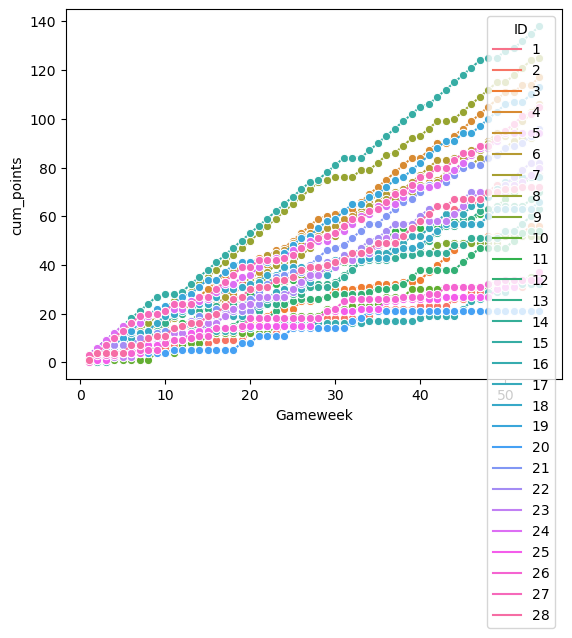

In [58]:
sns.lineplot(data=points_by_week_s1_ordered, x='Gameweek', y='cum_points', hue='ID', marker='o')

In [62]:
# How many points are still available for each team each week (starting from 54 * 3 in week 0)
total_games = points_by_week_s1_ordered.groupby('ID')['Points'].count().mean()
win_points = 3
points_by_week_s1_ordered['max_remaining'] = (total_games - points_by_week_s1_ordered['Gameweek']) * win_points
points_by_week_s1_ordered['max_potential'] = (points_by_week_s1_ordered['max_remaining'] + 
                                              points_by_week_s1_ordered['cum_points'])
# Add leader look up
max_points_lu = points_by_week_s1_ordered.groupby('Gameweek')['cum_points'].max().reset_index()
max_points_lu.columns = ['Gameweek', 'leader_points']
points_by_week_s1_ordered_lu = points_by_week_s1_ordered.merge(max_points_lu, on=['Gameweek'])

# If the leader gets 0 in all remaining games, a team can still win if they win all remaining and max_potential
# is higher than leader points
points_by_week_s1_ordered_lu['canwin'] = (points_by_week_s1_ordered_lu.groupby('Gameweek').apply(
                                            lambda x : x['max_potential'] > x['leader_points'])
                                          .reset_index()[0])

In [64]:
# When only 1 team remains, they have won the league
can_win_tot = points_by_week_s1_ordered_lu.groupby('Gameweek')['canwin'].sum().reset_index()
can_win_tot[can_win_tot['canwin'] == 1]['Gameweek'].min()

50

In [67]:
# Biggest upset will be when the biggest odds
odds = pd.read_csv('../data/odds.csv')

results_odds = results[['MatchID', 'SeasonID','HomePoints']].merge(odds, on=['MatchID'])

results_odds_s1 = results_odds[results_odds['SeasonID']==1].copy()

results_odds_s1['HomeWin'] = results_odds_s1['HomePoints'] == 3
results_odds_s1['HomeDraw'] = results_odds_s1['HomePoints'] == 1
results_odds_s1['AwayWin'] = results_odds_s1['HomePoints'] == 0

In [68]:
results_odds_s1['upset_total'] = (results_odds_s1['Home'] * results_odds_s1['HomeWin'] + 
                                  results_odds_s1['Draw'] * results_odds_s1['HomeDraw'] + 
                                  results_odds_s1['Away'] * results_odds_s1['AwayWin'])

In [73]:
results_odds_s1.sort_values('upset_total', ascending=False).head()

,MatchID,SeasonID,HomePoints,Home,Draw,Away,HomeWin,HomeDraw,AwayWin,upset_total
167,168,1,1,1.03,23.35,75.22,False,True,False,23.35
384,385,1,1,1.04,20.52,48.07,False,True,False,20.52
714,715,1,0,1.16,9.29,17.44,False,False,True,17.44
17,18,1,3,13.01,6.37,1.26,True,False,False,13.01
521,522,1,1,1.09,12.72,32.09,False,True,False,12.72


In [89]:
biggest_upset = (results_odds_s1[results_odds_s1['upset_total'].max()==results_odds_s1['upset_total']].merge(results[['MatchID', 'HomeTeamID', 'AwayTeamID']],
                                                                        on='MatchID')
                 .merge(teams, left_on='HomeTeamID', right_on='TeamID')
                 .rename(columns={'TeamName': 'HomeTeamName'})
                 .drop('TeamID', axis=1)
                 .merge(teams, left_on='AwayTeamID', right_on='TeamID')
                 .rename(columns={'TeamName': 'AwayTeamName'})
                 .drop('TeamID', axis=1))

In [90]:
biggest_upset

,MatchID,SeasonID,HomePoints,Home,Draw,Away,HomeWin,HomeDraw,AwayWin,upset_total,HomeTeamID,AwayTeamID,HomeTeamName,AwayTeamName
0,168,1,1,1.03,23.35,75.22,False,True,False,23.35,15,16,Miami,Milwaukee
